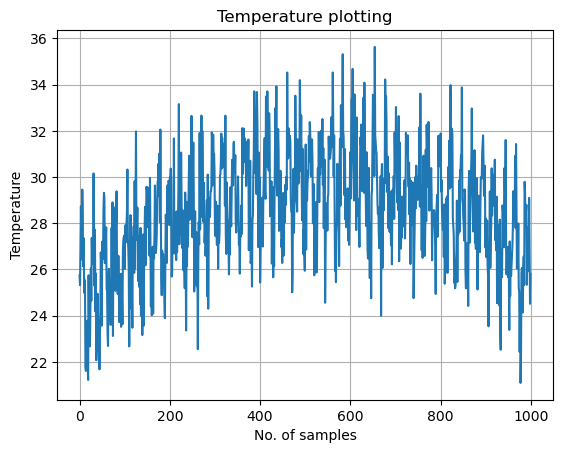

Number of samples in the temperature data:  20000
No of days:  833.3333333333334
The max temperature is:  15843
The min temperature is:  8200


In [17]:
#2.1 Data Loading 

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz
import pandas as pd
import time

# Load the noisy temperature data from CSV
df = pd.read_csv("noisy_temperature_data.csv")
noisy_temperature_data = df["Noisy_Temperature"].values
Fs = 1 # Sampling rate is 1 sample per hour, from data generation
total_samples = len(noisy_temperature_data)

plt.plot(np.arange(1000),noisy_temperature_data[:1000])
plt.xlabel("No. of samples")
plt.ylabel("Temperature")
plt.title("Temperature plotting")
plt.grid()
plt.show()

#PTQ_2
print("Number of samples in the temperature data: ",total_samples)

time_hours = df["Time_Hours"].values
time_end = len(time_hours)
print("No of days: ",time_end/24)

#PTQ_3
print("The max temperature is: ", np.argmax(noisy_temperature_data))
print("The min temperature is: ", np.argmin(noisy_temperature_data))

Designed FIR filter of length M = 101


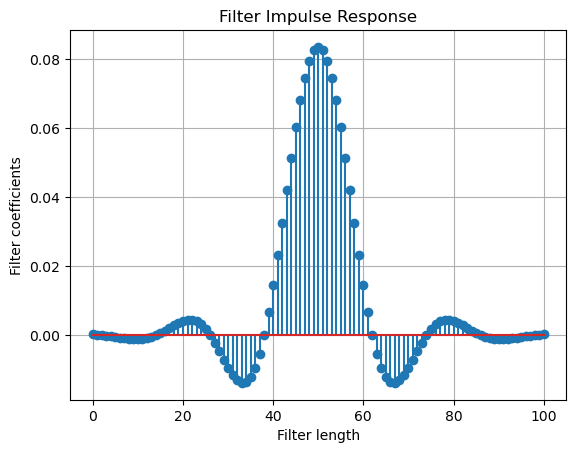

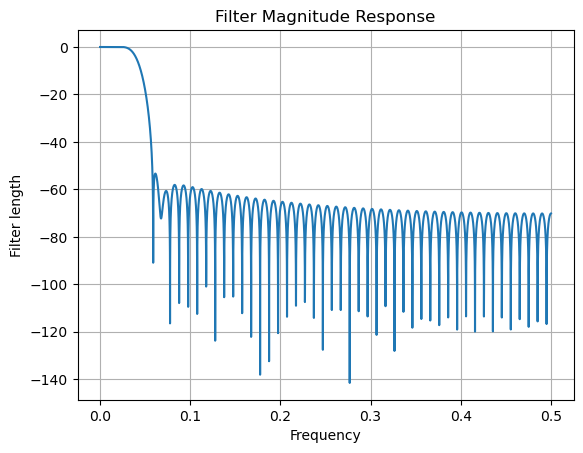

From the magnitude response, the designed filter is a: LOW PASS FILTER
The 3dB cut-off frequency of the filter is 0.0377197265625


In [7]:
#2.2.1 Filter Design

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz
import pandas as pd
import time

# Load the noisy temperature data from CSV
df = pd.read_csv("noisy_temperature_data.csv")
noisy_temperature_data = df["Noisy_Temperature"].values
Fs = 1 # Sampling rate is 1 sample per hour, from data generation
total_samples = len(noisy_temperature_data)

filter_order = 100 # M-1
cutoff_freq_norm = 1 / (2 * 24) / (Fs / 2)

# h - filter coefficients (or impulse repsonse of the filter)
h = firwin(filter_order + 1, cutoff_freq_norm, pass_zero=True, fs=Fs)
M = len(h) # Actual filter length
print(f"Designed FIR filter of length M = {M}")

plt.stem(np.arange(M),h)
plt.title("Filter Impulse Response")
plt.ylabel("Filter coefficients")
plt.xlabel("Filter length")
plt.grid()
plt.show()


#2.2.2 Frequency Response of Filter
w, H = freqz(h, worN=8192, fs=Fs) # worN is number of points, fs is sample rate
plt.plot(w,20*np.log10(abs(H)))
plt.title("Filter Magnitude Response")
plt.xlabel("Frequency")
plt.ylabel("Filter length")
plt.grid()
plt.show()

#PTQ_6
print("From the magnitude response, the designed filter is a: LOW PASS FILTER")

#PTQ_7
find_3dB= np.where(20*np.log10(abs(H))<= -3)[0][0]
cutoff= w[find_3dB]
print("The 3dB cut-off frequency of the filter is", cutoff)



In [30]:

#2.3 Overlap-Add (OLA) Implementation

#2.3.1 Setup Parameters and Pre-compute FFT of Filter:

L = 1024 # Input: each non-overlapping block length
N = total_samples
# P: FFT length for block convolution:
P = int(2**np.ceil(np.log2(N)))
M = len(h)

print("The total number of samples (N): ", N)
print("The length of each non-overlapping block: ", L)
print("The FFT length for block convolution: ", P)
print("Designed FIR filter is of length: ", M)

# Pre-computing DFT of filter impulse response (padded to P)
np.zeros(N+M-1)
def overlap_add(x,h,L,P):
    M=len(h)
    N=len(x)
    h_fft=np.fft.fft(h,P)
    y_ola=np.zeros(N+M-1)
    num_block=int(np.ceil(N/L))
    start_time=time.time()
    for i in range(num_block):
        start=i*L
        end=min(start+L,N)
        block_list=x[start:end]
        block_list_padded=np.zeros(P)
        block_list_padded[:len(block_list)]= block_list
        X_block=np.fft.fft(block_list_padded)
        Y_block = X_block * h_fft
        y_block=np.real(np.fft.ifft(Y_block))
        y_ola[start: start + P] += y_block[0 : P]
    end_time = time.time()
    return y_ola,(end_time-start_time)

filtered_ola_output = overlap_add(noisy_temperature_data, h, L, P)


#PTQ_9
print("The time of execution of overlap add is: ", filtered_ola_output[1])
print(filtered_ola_output[0])


The total number of samples (N):  20000
The length of each non-overlapping block:  1024
The FFT length for block convolution:  32768
Designed FIR filter is of length:  101


ValueError: operands could not be broadcast together with shapes (20100,) (32768,) (20100,) 